# 误差方向传播法的实现

In [1]:
import numpy as np
from common.functions import *
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1']) # 输入层到隐藏层的权重和偏置
        self.layers['Relu1'] = Relu() # 隐藏层，Relu激活函数
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2']) # 隐藏层到输出层的权重和偏置
        self.lastLayer = SoftmaxWithLoss() # 输出层，SoftmaxWithLoss损失函数

    def predict(self, x):
        # 前向传播, 计算预测值
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        # 前向传播, 计算损失
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        # 计算梯度, 数值微分
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # 计算梯度, 反向传播
        self.loss(x, t) # 计算损失

        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse() # 反转各层顺序，从后往前，反向传播。
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


### 误差反向传播法的梯度确认

目前，已经了解了两种梯度计算方法：基于数值微分法和基于误差反向传播法。后者，即误差反向传播法，是深度学习领域中常用的梯度计算方法，即使存在大量的参数，也可以高效地计算梯度。

虽然数值微分用在梯度计算中效率不高，但数值微分法可以用来确认梯度计算结果是否正确。

确认数值微分求出的梯度结果和误差反向传播法求出的结果是否一致（严格地讲，是非常相近）的操作称为**梯度确认（gradient check）**。

In [3]:
import numpy as np
from dataset.mnist import load_mnist

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normolize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=10, output_size=10)
x_batch = x_train[ : 3]
t_batch = t_train[ : 3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 求各个权重的绝对误差的平均值
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ": " + str(diff))


Loading dataset ...
W1: 0.0004942659786859975
b1: 0.0029082249047275386
W2: 0.005785432008109274
b2: 0.28001949666875


以上代码，使用了训练数据的一部分，确认数值微分求出的梯度与误差反向传播求出的梯度之间的误差。这里误差的计算方法是，求各个权重参数中对应元素的差的绝对值，并求平均值。

可以看出，通过数值微分和反向误差传播法求出的梯度差异非常小。从而，可知误差反向传播法求出的梯度是正确的。

> 一般来说，数值微分法求出的梯度与误差反向传播法求出的梯度差异在1e-5左右。但是，如果梯度差异大于1e-5，则说明误差反向传播法求出的梯度有误。

### 使用误差方向传播法进行训练

Loading dataset ...
train acc, test acc | 0.15108333333333332, 0.1574
train acc, test acc | 0.9047, 0.9082
train acc, test acc | 0.9262333333333334, 0.9291
train acc, test acc | 0.9372333333333334, 0.9353
train acc, test acc | 0.9446833333333333, 0.9426
train acc, test acc | 0.9502833333333334, 0.9465
train acc, test acc | 0.9559666666666666, 0.953
train acc, test acc | 0.9571333333333333, 0.9523
train acc, test acc | 0.9625166666666667, 0.9583
train acc, test acc | 0.96535, 0.9603
train acc, test acc | 0.9676666666666667, 0.9632
train acc, test acc | 0.97015, 0.9644
train acc, test acc | 0.9712333333333333, 0.9641
train acc, test acc | 0.9742, 0.9652
train acc, test acc | 0.9744666666666667, 0.9658
train acc, test acc | 0.9770666666666666, 0.967
train acc, test acc | 0.9767, 0.9663
Finished!


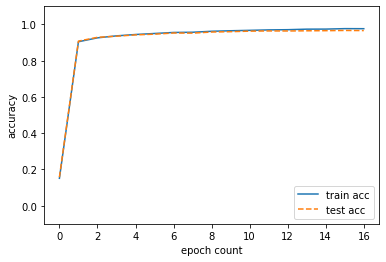

In [7]:
import numpy as np
from dataset.mnist import load_mnist
from common.two_layers_net import TwoLayerNet

 # 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normolize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000 # 迭代次数
train_size = x_train.shape[0] # 训练集大小
batch_size = 100 # 每次训练的大小
learning_rate = 0.1 # 学习率

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 开始训练
iter_per_epoch = max(train_size / batch_size, 1) # 每个epoch需要迭代的次数

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size) # 随机选择一个批次的数据。即，在0-train_size中随机选择batch_size个数据。
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 通过反向传播计算梯度，loss_b是本轮训练后，更新参数之前的loss值。
    grad, loss_b = network.gradient(x_batch, t_batch) # 计算梯度

    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 更新参数后的，本轮训练的loss值。
    loss_a = network.loss(x_batch, t_batch)
    train_loss_list.append(loss_a)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

print("Finished!")

# 绘制loss曲线
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label="train acc")
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label="test acc", linestyle='--')
plt.xlabel("epoch count")
plt.ylabel("accuracy")
plt.ylim([-0.1, 1.1]) # 设置y轴的取值范围
plt.legend(loc="lower right")
plt.show()